In [1]:
import sys; sys.path.append("../")

from vle.utils import instantiate_from_config, load_config

import torchvision.transforms as transforms
import torchvision

from torch.utils.data import DataLoader
import torch.nn.functional as F

import torch

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

In [2]:
### Comparisons ###

# config = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-25T00-42-45_memory_network/training_config_laion-07.yaml"
# weights = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-25T00-42-45_memory_network/checkpoints/trainstep_checkpoints/last.ckpt"

# config = load_config(config)
# model2 = instantiate_from_config(config["model"])
# model2.load_weights(weights, verbose=True)
# model2 = model2.cuda().eval()

# config = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-25T00-43-22_memory_network/training_config_laion-07-test.yaml"
# weights = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-25T00-43-22_memory_network/checkpoints/trainstep_checkpoints/last.ckpt"

# config = load_config(config)
# model1 = instantiate_from_config(config["model"])
# model1.load_weights(weights, verbose=True)
# model1 = model1.cuda().eval()

### Single model ###
# config = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-07T07-01-55_8x_ds_latent_space_laion/training_config_laion-06.yaml"
# weights = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-07T07-01-55_8x_ds_latent_space_laion/checkpoints/trainstep_checkpoints/last.ckpt"
# config = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-28T02-22-31_encoder-lstm-higher-position/training_config_laion-09.yaml"
# weights = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-28T02-22-31_encoder-lstm-higher-position/checkpoints/trainstep_checkpoints/last.ckpt"
config = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-28T18-04-45_encoder-lstm-higher-position-bce/training_config_laion-11.yaml"
weights = "/fsx/home/johnathan/variable-length-embeddings/logs/2023-03-28T18-04-45_encoder-lstm-higher-position-bce/checkpoints/trainstep_checkpoints/last.ckpt"

config = load_config(config)
model1 = instantiate_from_config(config["model"])
model1.load_weights(weights, verbose=True)
model1 = model1.cuda().eval()


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
/fsx/home/johnathan/miniconda3/envs/vle/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/fsx/home/johnathan/miniconda3/envs/vle/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /fsx/home/johnathan/variable-length-embeddings/develop/PerceptualSimilarity/lpips/weights/v0.1/alex.pth
Weights sucessfully loaded!


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((512, 512)),
])
data = torchvision.datasets.INaturalist(
    root="/fsx/home/johnathan/data", 
    version='2021_valid', 
    transform=transform, 
    download=False,
)
data = DataLoader(
    data,
    batch_size=5,
    shuffle=True,
    num_workers=12,
)

In [70]:
import skimage.measure as measure

n_tokens = 4

@torch.no_grad()
def compute_metrics(model, data, n_tokens):
    mses = []
    entropies = []
    count = 0
    for imgs, _ in data:
        imgs = imgs.cuda()
        bs, ch, height, width = imgs.shape
        rec = torch.zeros_like(imgs)

        mses.append([])
        for _ in range(n_tokens): 
            err = imgs - rec
            mean = torch.mean(err, dim=(-1, -2), keepdims=True)
            std = torch.std(err, dim=(-1, -2), keepdims=True)
            z = model.enc((err - mean) / std)
            rec = rec + (model.dec(z) * std + mean)

            mses[-1].append(torch.mean((rec - imgs) ** 2, dim=(1,2,3)))

        for img in imgs:
            entropies.append(measure.shannon_entropy(img.cpu().detach().moveaxis(0,-1).numpy()))

        mses[-1] = torch.stack(mses[-1], dim=1)

        if count >= 100:
            break
        count += 1

    mses = torch.cat(mses, dim=0)
    entropies = np.array(entropies)
    
    return mses, entropies

mses, entropies = compute_metrics(model, data, n_tokens)

AttributeError: 'str' object has no attribute 'enc'

Text(0, 0.5, 'MSE')

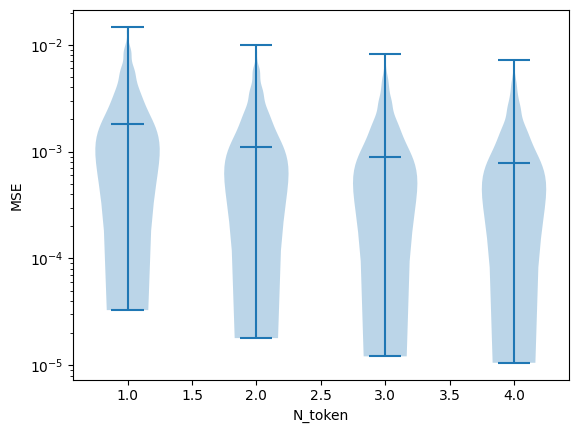

In [6]:
plt.violinplot(mses.cpu().detach().numpy(), showmedians=True);
plt.yscale("log"); plt.xlabel("N_token"); plt.ylabel("MSE")

Text(0, 0.5, 'Skimage shannon entropy')

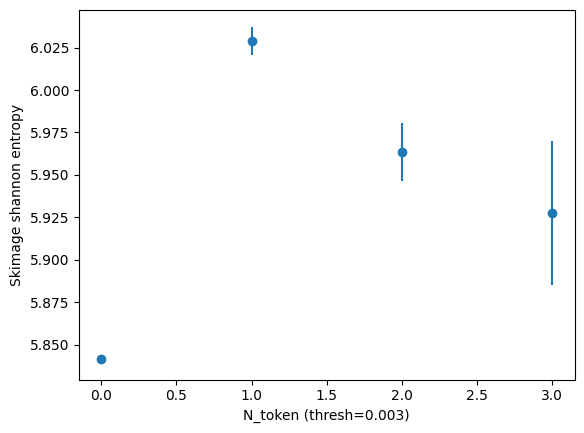

In [7]:
thresh = 0.003
tmp = lambda x: np.argwhere(x).min() if len(np.argwhere(x)) > 0 else n_tokens
toks = np.array([tmp(x) for x in (mses < thresh).cpu().detach().numpy()])
# plt.scatter(toks, entropies, s=1)
for i in range(n_tokens):
    zz = entropies[toks == i]
    if np.sum(toks == i) == 0: continue
    plt.errorbar(i, np.mean(zz), yerr=np.std(zz)/len(zz), c='tab:blue')
    plt.scatter(i, np.mean(zz), c='tab:blue')3
plt.xlabel("N_token (thresh=0.003)")
plt.ylabel("Skimage shannon entropy")

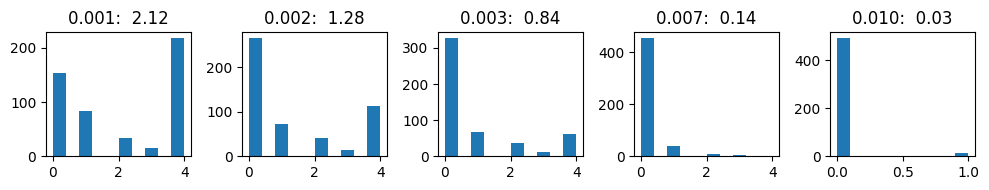

In [8]:
fig, axes = plt.subplots(1, 5, figsize=(10,2))
for i, thresh in enumerate([0.001, 0.002, 0.003, 0.007, 0.01]):
    tmp = lambda x: np.argwhere(x).min() if len(np.argwhere(x)) > 0 else n_tokens
    toks = np.array([tmp(x) for x in (mses < thresh).cpu().detach().numpy()])
    axes[i].hist(toks)
    axes[i].set_title("%.3f: %5.2f" % (thresh, np.mean(toks)))
fig.tight_layout()

In [8]:
batch = next(iter(data))

In [ ]:
# models = [model2, model1]
models = [model1]

torch.set_grad_enabled(False)

for model in models:
    postprocess = lambda x: np.clip((x.moveaxis(0, -1).cpu().detach().numpy() * 255), 0, 255).astype(int)
    inputs, labels = batch
    inputs = inputs.cuda()
    bs, ch, height, width = inputs.shape

    rec = torch.zeros_like(inputs)
    hidden_states = model.initialize_hidden_states(inputs) if model.memory_network is not None else None

    n_tokens = 12
    fig, axes = plt.subplots(3, n_tokens, figsize=(20,4))
    example_idx = 1
    a,b = None, None
    for j in range(n_tokens): 
        err = inputs - rec
        mean = torch.mean(err, dim=(-1, -2), keepdims=True)
        std = torch.std(err, dim= (-1, -2), keepdims=True)
        delta = (err - mean) / std

        z, hidden_states = model.encode(delta, hidden_states)
        i_rec = model.decode(z)

        rec = rec + (i_rec * std + mean)
        hm = np.linalg.norm(postprocess(delta[example_idx]), axis=-1)
        axes[0,j].contourf(hm, cmap='hot', origin='image')
        axes[0,j].axis('off')
        axes[1,j].hist((inputs - rec).cpu().detach().numpy().flatten(), bins=50)
        plot_delt = postprocess((inputs - rec)[example_idx])
        plot_delt = (plot_delt / np.max(plot_delt)) * 255
        axes[2,j].imshow(plot_delt.astype(int))
        print(j+1, F.mse_loss(inputs, rec).item())
        if j == 4: a = rec.clone()
        if j == 7: b = rec.clone() 

    print()
    if hasattr(model.enc, "reset_hidden_state"):
        model.enc.reset_hidden_state()
            
    fig.tight_layout()
        
    plt.figure(figsize=(15, 7), tight_layout=True)
    plt.subplot(131)
    plt.title("Original")
    plt.imshow(postprocess(inputs[example_idx]))
    plt.subplot(132)
    plt.title("Recconstruction")
    plt.imshow(postprocess(rec[example_idx]))
    plt.subplot(133)
    plt.title("Intermediate (n_tok=7)")
    plt.imshow(postprocess(b[example_idx]))

1 0.005828233901411295
2 0.00420095631852746
3 0.0032186913304030895
4 0.0027683868538588285
5 0.002539204666391015
6 0.002399708842858672


In [ ]:
from tqdm.auto import *
inputs, labels = batch
inputs= inputs
bs, ch, height, width = inputs.shape

rec = torch.zeros_like(inputs)

n_tokens = 8
example_idx = 2
a,b = None, None
errs = []
for j in trange(n_tokens): 
    z = enc(inputs-rec)
    delta = dec(z)
    rec += delta
    errs.append(torch.mean((inputs-rec)**2, dim=(1,2,3)))
errs = torch.stack(errs, dim=0)

  0%|          | 0/8 [00:00<?, ?it/s]

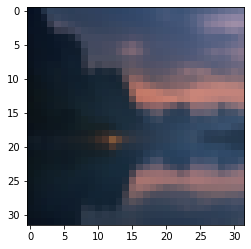

In [ ]:
from skimage.transform import rescale, resize

img = plt.imread("landscape.jpg")
img = img[:484,:484]
img = resize(img, (32,32))
orig_img = img
plt.imshow(img)
img = torch.tensor(img).moveaxis(-1,0).cuda().unsqueeze(0).float()

In [ ]:
rec = torch.zeros_like(img)
tmp = None
for j in range(n_tokens): 
    z = enc(img-rec)
    
    delta = dec(z)
    rec += delta

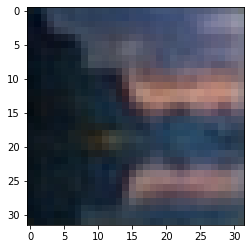

In [ ]:
plt.imshow(rec[0].moveaxis(0,-1).cpu().detach().numpy())